# Lab3 - AI - Convolutional Neural networks for image recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

**Setting up the environment**


In [ ]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
# what is your GPU ?
!nvidia-smi

Thu May 23 08:58:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A | Not Supported        |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  CNNs for Cifar10 - training from scratch

Now let's build CNN models to work on the CIFAR10 dataset.

Try to reach the best performance on validation by designing other CNNs.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

100.0%


Extracting DATA_CIFAR/cifar-10-python.tar.gz to DATA_CIFAR/
Files already downloaded and verified


In [ ]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [ ]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 3, 32, 32])
torch.Size([64])


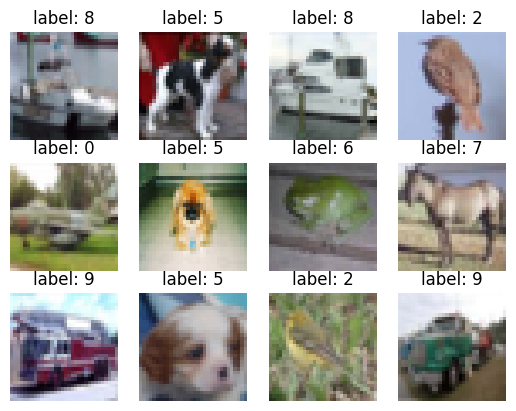

In [25]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [ ]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # different from Mnist car ce sont les images couleur
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

579402


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/20   Training loss: 2.2547   Validation loss: 2.1412   Train accuracy: 0.1574   Validation accuracy: 0.2715  
Epoch: 1/20   Training loss: 1.9840   Validation loss: 1.8759   Train accuracy: 0.3034   Validation accuracy: 0.3344  
Epoch: 2/20   Training loss: 1.8080   Validation loss: 1.7360   Train accuracy: 0.3614   Validation accuracy: 0.3830  
Epoch: 3/20   Training loss: 1.6823   Validation loss: 1.6314   Train accuracy: 0.4062   Validation accuracy: 0.4065  
Epoch: 4/20   Training loss: 1.5709   Validation loss: 1.5144   Train accuracy: 0.4398   Validation accuracy: 0.4591  
Epoch: 5/20   Training loss: 1.4889   Validation loss: 1.5148   Train accuracy: 0.4667   Validation accuracy: 0.4636  
Epoch: 6/20   Training loss: 1.4322   Validation loss: 1.4242   Train accuracy: 0.4888   Validation accuracy: 0.4893  
Epoch: 7/20   Training loss: 1.3881   Validation loss: 1.3653   Train accuracy: 0.5074   Validation accuracy: 0.5127  
Epoch: 8/20   Training loss: 1.3513   Validation

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

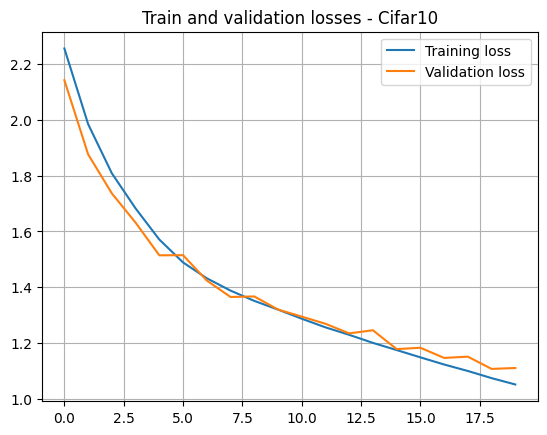

In [ ]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

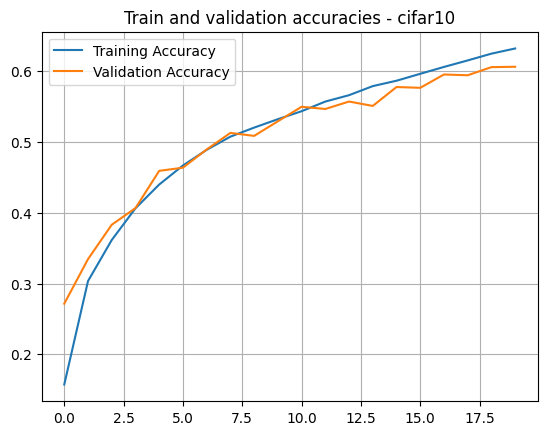

In [ ]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

## Transfer learning with pre-trained networks

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


**Transfer learning with Resnet18 - feature extraction technique**

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mathi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [ ]:
model = model_conv
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

5130


# CNNs for Cifar10 - training from CNN(1,2) (feat_extract, fine_tuning)

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torchvision import models
import pandas as pd

# Préparation des Données CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les classes CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Déplacer le modèle vers le GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [35]:
# Définir la méthode d'entraînement
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects.double() / len(trainloader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, time_elapsed, num_epochs

In [ ]:
# 1. VGG16 Feature Extraction
model_vgg_feat = models.vgg16(pretrained=True)
for param in model_vgg_feat.parameters():
    param.requires_grad = False
model_vgg_feat.classifier[6] = nn.Linear(model_vgg_feat.classifier[6].in_features, 10)
model_vgg_feat = model_vgg_feat.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg_feat = optim.SGD(model_vgg_feat.classifier[6].parameters(), lr=0.001, momentum=0.9)
scheduler_vgg_feat = lr_scheduler.StepLR(optimizer_vgg_feat, step_size=7, gamma=0.1)

# Entraîner le modèle
model_vgg_feat, time_vgg_feat_train, epochs_vgg_feat = train_model(model_vgg_feat, criterion, optimizer_vgg_feat, scheduler_vgg_feat)
accuracy_vgg_feat, time_vgg_feat_eval = evaluate_model(model_vgg_feat)

# 2. VGG16 Fine-tuning
model_vgg_finetune = models.vgg16(pretrained=True)
model_vgg_finetune.classifier[6] = nn.Linear(model_vgg_finetune.classifier[6].in_features, 10)
model_vgg_finetune = model_vgg_finetune.to(device)

optimizer_vgg_finetune = optim.SGD(model_vgg_finetune.parameters(), lr=0.001, momentum=0.9)
scheduler_vgg_finetune = lr_scheduler.StepLR(optimizer_vgg_finetune, step_size=7, gamma=0.1)

# Entraîner le modèle
model_vgg_finetune, time_vgg_finetune_train, epochs_vgg_finetune = train_model(model_vgg_finetune, criterion, optimizer_vgg_finetune, scheduler_vgg_finetune)
accuracy_vgg_finetune, time_vgg_finetune_eval = evaluate_model(model_vgg_finetune)

# 3. ResNet18 Feature Extraction
model_resnet_feat = models.resnet18(pretrained=True)
for param in model_resnet_feat.parameters():
    param.requires_grad = False
num_ftrs = model_resnet_feat.fc.in_features
model_resnet_feat.fc = nn.Linear(num_ftrs, 10)
model_resnet_feat = model_resnet_feat.to(device)

optimizer_resnet_feat = optim.SGD(model_resnet_feat.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_resnet_feat = lr_scheduler.StepLR(optimizer_resnet_feat, step_size=7, gamma=0.1)

# Entraîner le modèle
model_resnet_feat, time_resnet_feat_train, epochs_resnet_feat = train_model(model_resnet_feat, criterion, optimizer_resnet_feat, scheduler_resnet_feat)
accuracy_resnet_feat, time_resnet_feat_eval = evaluate_model(model_resnet_feat)

# 4. ResNet18 Fine-tuning
model_resnet_finetune = models.resnet18(pretrained=True)
num_ftrs = model_resnet_finetune.fc.in_features
model_resnet_finetune.fc = nn.Linear(num_ftrs, 10)
model_resnet_finetune = model_resnet_finetune.to(device)

optimizer_resnet_finetune = optim.SGD(model_resnet_finetune.parameters(), lr=0.001, momentum=0.9)
scheduler_resnet_finetune = lr_scheduler.StepLR(optimizer_resnet_finetune, step_size=7, gamma=0.1)

# Entraîner le modèle
model_resnet_finetune, time_resnet_finetune_train, epochs_resnet_finetune = train_model(model_resnet_finetune, criterion, optimizer_resnet_finetune, scheduler_resnet_finetune)
accuracy_resnet_finetune, time_resnet_finetune_eval = evaluate_model(model_resnet_finetune)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24 Loss: 1.5771 Acc: 0.4474
Epoch 1/24 Loss: 1.4654 Acc: 0.4826
Epoch 2/24 Loss: 1.4391 Acc: 0.4929
Epoch 3/24 Loss: 1.4391 Acc: 0.4943
Epoch 4/24 Loss: 1.4284 Acc: 0.4990


In [33]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    elapsed_time = time.time() - start_time
    print(f'Accuracy: {accuracy}%')
    print(f'Evaluation Time: {elapsed_time:.2f} seconds')
    return accuracy, elapsed_time

In [30]:
# Créer un tableau comparatif des résultats
data = {
    "Approach": ["Feature Extraction", "Fine-tuning", "Feature Extraction", "Fine-tuning"],
    "Model": ["VGG16", "VGG16", "ResNet18", "ResNet18"],
    "Accuracy": [accuracy_vgg_feat, accuracy_vgg_finetune, accuracy_resnet_feat, accuracy_resnet_finetune],
    "Training Time (s)": [time_vgg_feat_train, time_vgg_finetune_train, time_resnet_feat_train, time_resnet_finetune_train],
    "Evaluation Time (s)": [time_vgg_feat_eval, time_vgg_finetune_eval, time_resnet_feat_eval, time_resnet_finetune_eval],
    "Epochs": [epochs_vgg_feat, epochs_vgg_finetune, epochs_resnet_feat, epochs_resnet_finetune]
}

df = pd.DataFrame(data)
print(df)

             Approach     Model  Accuracy
0  Feature Extraction     VGG16     60.80
1         Fine-tuning     VGG16     87.52
2  Feature Extraction  ResNet18     42.08
3         Fine-tuning  ResNet18     81.23
